In [ ]:
import requests
import string
import re
import json
import random
from itertools import permutations # Oh no

# How to Play Letter Boxed like a Data Scientist

In this notebook, I walk through my thought process finding every solution to today's Letter Boxed. Ultimately, I land on an iterative depth-first search with backtracking. My solution can solve some `par = 5` puzzles, but `par = 6` remains unfeasible.

## Introduction

In February 2019, [The New York Times](https://www.nytimes.com/) introduced [Letter Boxed](https://www.nytimes.com/puzzles/letter-boxed), a letter-based puzzle game. If you haven't already, you should play today's puzzle.

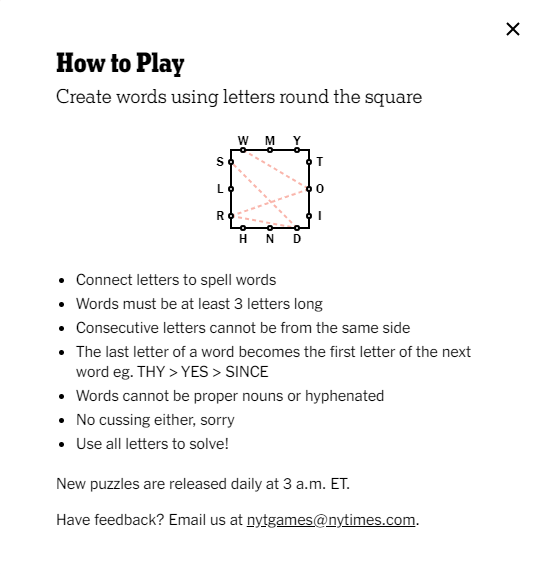

Additionally, each puzzle must be solved in `par` or less words.

In December 2023, the University of Maryland Libraries purchased an institutional subscription to the The New York Times. Since then, I've really enjoyed playing Letter Boxed.

As a data science student, I thought this was great opportunity to use data science to solve a hard problem. Specifically, I wanted to find every solution to the Letter Boxed. In this notebook, I'm going to walk through my thought process solving this problem.

## Data Wrangling

Each puzzle has a `dictionary` (list of legal words) and `par` (maximum number of words allowed in a solution), which are stored in the `gameData`. To get `gameData`, we'll:

1.   Request the Letter Boxed page
2.   Find the `gameData` JSON string
3.   Parse the JSON into a dictionary

In [ ]:
response = requests.get('https://www.nytimes.com/puzzles/letter-boxed')
match_ = re.search(r'window\.gameData = ({.*?})', response.text)
gameData = json.loads(match_.group(1))
dictionary, par = gameData['dictionary'], gameData['par']

print(f'''dictionary = ['{"', '".join(dictionary[:5])}', ...]''')
print(f'len(dictionary) = {len(dictionary)}')
print(f'par = {par}')

dictionary = ['AKARA', 'AERIAL', 'AHA', 'AHI', 'AIL', ...]
len(dictionary) = 977
par = 5


This problem has a huge [search space](https://en.wikipedia.org/wiki/Search_space). Specifically, it's:

$$\sum_{i=1}^{r}{}_nP_i$$

where $n$ is `len(dictionary)` and $r$ is `par`. For `len(dictionary) = 1000` and `par = 5`, that's 991,029,959,020,000 possible solutions. So, to make this notebook easier to run, we'll limit `len(dictionary)` to `300` and `par` to `3`. That's still 26,820,600 possible solutions.

In [ ]:
dictionary, par = random.sample(dictionary, 300), 3

print(f'''dictionary = ['{"', '".join(dictionary[:5])}', ...]''')
print(f'len(dictionary) = {len(dictionary)}')
print(f'par = {par}')

dictionary = ['ELK', 'PLIP', 'HAHAM', 'REPEAL', 'MIHANERE', ...]
len(dictionary) = 300
par = 3


## Naive Search

My first idea was to check all possible solutions. For this, I used a for loop to check each `permutation` and ask:

1.   Does the last letter of each word match the first letter of the next?
2.   Does the `permutation` use all 12 letters?
3.   Does `permutation[:-1]` not use all 12 letters?

What about that last question? Well, imagine we have sides `['HNA', 'MOL', 'ITB', 'SUF']`. The solution `('FASHIONISTA', 'ALBUM', 'MAIN')` satisfies the first two conditions. However, so does just `('FASHIONISTA', 'ALBUM')`. So, if we try to enter `('FASHIONISTA', 'ALBUM', 'MAIN')`, the game will end before we get to `'MAIN'`.

In [ ]:
def naive_search(dictionary, par):
    return [
        permutation for i in range(1, par + 1)
        for permutation in permutations(dictionary, i)
        if all(a[-1] == b[0] for a, b in zip(permutation, permutation[1:]))
        and len({letter for word in permutation for letter in word}) == 12
        and len({letter for word in permutation[:-1] for letter in word}) != 12
    ]

solutions = naive_search(dictionary, par)

print(f'solutions = [{solutions[0]}, {solutions[1]}, ...]')
print(f'len(solutions) = {len(solutions)}')

solutions = [('PLENARIUM', 'MUKHIYA'), ('PLIP', 'PLENARIUM', 'MUKHIYA'), ...]
len(solutions) = 512


This idea works, but it [scales](https://en.wikipedia.org/wiki/Scalability) poorly. Even for `len(dictionary) = 300` and `par = 3`, it takes about 30 seconds to finish. So for `len(dictionary) = 1000` and `par = 5`, it would take about 35 years.

$$30\text{ seconds} \left( \frac{991029959020000}{26820600} \right) \approx 1.109 \times 10^9\text{ seconds} \approx 35.13 \text{ years}$$

So, let's try another idea.

## Recursive Depth-First Search

My next idea was to use a [recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science)) [depth-first search](https://en.wikipedia.org/wiki/Depth-first_search). Except, instead of checking the entire search space, we'll [backtrack](https://en.wikipedia.org/wiki/Backtracking) when we find a solution. This'll not only reduce the search space, but also remove the `permutation[:-1]` check.

First, we'll search a `path`:

1.   If the `path` uses all twelve letters, we'll accept the solution and backtrack.
2.   If we've reached the `par`, we'll backtrack.
3.   Otherwise, we'll search a new `path`.

Eventually, we'll exhaust all paths.

In [ ]:
def recursive_depth_first_search(dictionary, par):
    solutions = []
    def search(path, par):
        if len({letter for word in path for letter in word}) == 12:
            solutions.append(path)
            return
        if par == 0:
            return
        for word in dictionary:
            if len(path) == 0 or path[-1][-1] == word[0]:
                search(path + (word,), par - 1)
    search((), par)
    return solutions

solutions = recursive_depth_first_search(dictionary, par)

print(f'solutions = [{solutions[0]}, {solutions[1]}, ...]')
print(f'len(solutions) = {len(solutions)}')

solutions = [('PLIP', 'PLENARIUM', 'MUKHIYA'), ('YIP', 'PLENARIUM', 'MAKHULU'), ...]
len(solutions) = 512


This is much better than my first idea. Now that we have a good algorithm, let's make some optimizations.

## Optimized Recursive Depth-First Search

We can make two optimizations. First, we can [cache](https://en.wikipedia.org/wiki/Cache_(computing)) the first and last letters of each word. This'll let us skip the `path[-1][-1]` check. Second, we can store the path's letters in a set. This'll reduce the time it takes to count the letters.

In [ ]:
def recursive_depth_first_search(dictionary, par):
    cache = {'*': {}}
    for word in dictionary:
        first, last = word[0], word[-1]
        if first not in cache:
            cache[first] = {}
        cache[first][word] = last
        cache['*'][word] = last
    solutions = []
    def search(path, par, last, letters):
        if len(letters) == 12:
            solutions.append(path)
            return
        if par == 0:
            return
        for word, last in cache[last].items():
            search(path + (word,), par - 1, last, letters | set(word))
    search((), par, '*', set())
    return solutions

solutions = recursive_depth_first_search(dictionary, par)

print(f'solutions = [{solutions[0]}, {solutions[1]}, ...]')
print(f'len(solutions) = {len(solutions)}')

solutions = [('PLIP', 'PLENARIUM', 'MUKHIYA'), ('YIP', 'PLENARIUM', 'MAKHULU'), ...]
len(solutions) = 512


Overall, I'm really happy with this result, and I think this is a good place to stop. But, let's try one more idea.

## Optimized Iterative Depth-First Search

My last idea was to use an [iterative](https://en.wikipedia.org/wiki/Iteration) depth-first search algorithm. I've read that iteration can be better than recursion ([source](https://en.wikipedia.org/wiki/Recursion_(computer_science)#Recursion_versus_iteration), [source](https://stackoverflow.com/questions/72209/recursion-or-iteration), [source](https://stackoverflow.com/questions/2651112/is-recursion-ever-faster-than-looping?noredirect=1&lq=1)). This is *exactly* the same as recursion, except we're using an explicit [call stack](https://en.wikipedia.org/wiki/Call_stack).

In [ ]:
def iterative_depth_first_search(dictionary, par):
    cache, stack = {}, []
    for word in dictionary:
        first, last = word[0], word[-1]
        if first not in cache:
            cache[first] = {}
        cache[first][word] = last
        stack.append(((word,), par - 1, last, set(word)))
    solutions = []
    while stack:
        path, par, last, letters = stack.pop()
        if len(letters) == 12:
            solutions.append(path)
            continue
        if par == 0:
            continue
        for word, last in cache[last].items():
            stack.append((path + (word,), par - 1, last, letters | set(word)))
    return solutions

solutions = iterative_depth_first_search(dictionary, par)

print(f'solutions = [{solutions[0]}, {solutions[1]}, ...]')
print(f'len(solutions) = {len(solutions)}')

solutions = [('YUM', 'MAKHULU', 'UNRIPE'), ('MUKHIYA', 'ALURE', 'ENPLANE'), ...]
len(solutions) = 512


So, it's not *exactly* the same. We get the same number of solutions, but the order is different. This is because the recursive version checks paths as it finds them, but the iterative version adds a bunch of paths to the stack and checks them in reverse. Both versions are valid depth-first searches. Additionally, both versions check the same number of paths.

## Comparison

So, let's compare these methods.

In [ ]:
# %timeit naive_search(dictionary, par)
%timeit recursive_depth_first_search(dictionary, par)
%timeit iterative_depth_first_search(dictionary, par)

170 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
262 ms ± 59.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In general, it looks like the iterative method is faster. Although, sometimes the recursive method performs better.

In both cases, there reaches a point where it just takes *forever* for the code the finish.

## Conclusion

So, that's the end of my project. Here is the complete code that you can copy and paste. Just a warning, this can solve some `par = 5` if `len(dictionary) <≈ 800`, but `par = 6` is unfeasible.

In [ ]:
import requests
import re
import json

def get_data(url):
    response = requests.get(url)
    match_ = re.search(r'window\.gameData = ({.*?})', response.text)
    gameData = json.loads(match_.group(1))
    return gameData['dictionary'], gameData['par']

def preprocess_data(dictionary, par):
    cache, stack = {}, []
    for word in dictionary:
        first, last = word[0], word[-1]
        if first not in cache:
            cache[first] = {}
        cache[first][word] = last
        stack.append(((word,), par - 1, last, set(word)))
    return cache, stack

def find_solutions(cache, stack):
    solutions = []
    while stack:
        path, par, last, letters = stack.pop()
        if len(letters) == 12:
            solutions.append(path)
            continue
        if par == 0:
            continue
        for word, last in cache[last].items():
            stack.append((path + (word,), par - 1, last, letters | set(word)))
    return solutions

if __name__ == '__main__':
    url = 'https://www.nytimes.com/puzzles/letter-boxed'
    dictionary, par = get_data(url)
    cache, stack = preprocess_data(dictionary, par)
    solutions = find_solutions(cache, stack)

Looking online, I found one similar project by [Phil McLaughlin](https://medium.com/@pnmclaugh/solving-letter-boxed-in-python-5e6cc4b216f9). Phil's and my projects both use depth-first searches with backtracking. However, his is recursive and mine is iterative. Additionally, Phil uses a really interesting data structure called a [trie](https://en.wikipedia.org/wiki/Trie).

After looking at many projects, it seems like the most common solution was recursive depth-first search with backtracking ([source](https://letterboxed.aliceyliang.com/), [source](https://github.com/A5HU705H/letter-boxed-solver), [source](https://github.com/alexroussos/letter-boxed), [source](https://github.com/J3RN/letter_boxed), [source](https://github.com/artificialfintelligence/MyLetterBoxedSolver), [source](https://github.com/jeremyephron/ny-times-letter-boxed-solver), [source](https://github.com/duetosymmetry/letter-boxed), [source](https://github.com/dcbriccetti/letter-boxed-game-solver/tree/main), [source](https://github.com/Pink-Hat-Hacker/letter-box-solver), [source](https://github.com/kieft1/letterboxed)). Additionally, most projects seem aimed to solve *any* Letter Boxed. For that reason, I've included some code to preprocess a generic dictionary in the appendix.

Overall, this was pretty fun. I enjoyed using data science to solve a pretty hard puzzle. Plus I got to practice some skills which might help me out in the long run, like web scraping and dynamic programming. I hope you enjoyed reading.

## Appendix

Sadly, [words](https://en.wikipedia.org/wiki/Words_(Unix)) is unavailable in Google Colab.

In [ ]:
![ -f /usr/share/dict/words ] && echo True || echo False

False


This code works with any newline-separated dictionary. I like [dolph's dictionary](https://github.com/dolph/dictionary/tree/master).

In [ ]:
url = 'https://raw.githubusercontent.com/dolph/dictionary/master/popular.txt'
dictionary = requests.get(url).text.split()

This code removes words with:

1.   Less than three characters
2.   Non-alphabetic characters
3.   Letters not in the puzzle
4.   Conscutive letters in the same side

It also converts the letters to uppercase.

In [ ]:
sides = ['HNA', 'MOL', 'ITB', 'SUF']
sides = {letter: side for side in sides for letter in side}

dictionary = [word.upper() for word in dictionary]
dictionary = [
    word for word in dictionary if len(word) > 2 and word.isalpha()
    and all(letter in sides for letter in word)
    and all(sides[a] != sides[b] for a, b in zip(word, word[1:]))
]

Here's how you can incorporate this into the final code:

In [ ]:
import requests
import re
import json
import string

def get_dictionary(url, sides):
    dictionary = requests.get(url).text.split()
    dictionary = [word.upper() for word in dictionary]
    sides = {letter: side for side in sides for letter in side}
    return [
        word for word in dictionary if len(word) > 2 and word.isalpha()
        and all(letter in sides for letter in word)
        and all(sides[a] != sides[b] for a, b in zip(word, word[1:]))
    ]

def preprocess_data(dictionary, par):
    cache, stack = {}, []
    for word in dictionary:
        first, last = word[0], word[-1]
        if first not in cache:
            cache[first] = {}
        cache[first][word] = last
        stack.append(((word,), par - 1, last, set(word)))
    return cache, stack

def find_solutions(cache, stack):
    solutions = []
    while stack:
        path, par, last, letters = stack.pop()
        if len(letters) == 12:
            solutions.append(path)
            continue
        if par == 0:
            continue
        for word, last in cache[last].items():
            stack.append((path + (word,), par - 1, last, letters | set(word)))
    return solutions

if __name__ == '__main__':
    url = 'https://raw.githubusercontent.com/dolph/dictionary/master/popular.txt'
    sides, par = ['HNA', 'MOL', 'ITB', 'SUF'], 4
    dictionary = get_dictionary(url, sides)
    cache, stack = preprocess_data(dictionary, par)
    solutions = find_solutions(cache, stack)